In [30]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MaxAbsScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, fbeta_score, confusion_matrix, balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dropout, BatchNormalization

In [2]:
# Constants
data_folder = 'data/'
image_size = (64, 64)

# Initialize lists for storing images and labels
image_data_flat = []  # For Epsilon-Isomap
image_data_3d = []    # For CNN
labels = []

# Load and preprocess images
for label in os.listdir(data_folder):
    subfolder_path = os.path.join(data_folder, label)
    
    if os.path.isdir(subfolder_path):
        for image_file in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_file)

            # Open, resize, and preprocess the image
            image = Image.open(image_path).convert('RGB').resize(image_size)
            image_array_flat = np.array(image).flatten()  # Flatten for Epsilon-Isomap
            image_array_3d = np.array(image) / 255.0      # Normalize for CNN
            
            # Append to respective lists
            image_data_flat.append(image_array_flat)
            image_data_3d.append(image_array_3d)
            labels.append(label)

# Convert lists to numpy arrays for easier processing
X_flat = np.array(image_data_flat)        # For Epsilon-Isomap
X_3d = np.array(image_data_3d)             # For CNN
y = np.array(labels)

# Encode labels to integers
label_map = {'glioma': 0, 'meningioma': 1, 'pituitary': 2, 'notumor': 3}
y_encoded = np.vectorize(label_map.get)(y)

# Split into training and testing sets
X_train_flat, X_test_flat, y_train, y_test = train_test_split(X_flat, y_encoded, test_size=0.2, random_state=6740)
X_train_3d, X_test_3d, _, _ = train_test_split(X_3d, y_encoded, test_size=0.2, random_state=6740)

In [3]:
# Helper function for confusion matrix visualization
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [4]:
scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X_flat)

In [31]:
# Perform KMeans clustering with cross-validation
def perform_kmeans_with_cv(X_flat, y, n_clusters=4, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=6740)
    accuracies = []
    balanced_accuracies = []

    for fold, (train_index, test_index) in enumerate(skf.split(X_flat, y)):
        # Split into train and validation sets
        X_train, X_test = X_flat[train_index], X_flat[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Apply KMeans clustering on the training data
        kmeans = KMeans(n_clusters=n_clusters, random_state=6740)
        train_clusters = kmeans.fit_predict(X_train)

        # Determine the majority class for each cluster
        cluster_labels = {}
        for cluster_id in range(n_clusters):
            cluster_points = y_train[train_clusters == cluster_id]
            majority_class = np.bincount(cluster_points).argmax()  # Find majority label in each cluster
            cluster_labels[cluster_id] = majority_class

        # Predict labels for validation data based on the closest cluster
        test_clusters = kmeans.predict(X_test)
        y_pred = np.array([cluster_labels[cluster] for cluster in test_clusters])

        # Calculate accuracy for the fold and store it
        accuracy = accuracy_score(y_test, y_pred)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        balanced_accuracies.append(balanced_accuracy)
        print(f"Fold {fold + 1} - Accuracy: {accuracy:.4f}, Balanced Accuracy: {balanced_accuracy:.4f}")

        # Plot confusion matrix for the last fold
        if fold == n_splits - 1:
            plot_confusion_matrix(y_test, y_pred, f"KMeans Confusion Matrix - Fold {fold + 1}")

    # Print average accuracy over all folds
    mean_accuracy = np.mean(accuracies)
    mean_balanced_accuracy = np.mean(balanced_accuracies)
    print(f"\nCross-Validated Accuracy: {mean_accuracy:.4f}, CV Balanced Accuracy: {mean_balanced_accuracy:.4f}")

Fold 1 - Accuracy: 0.5437, Balanced Accuracy: 0.5609
Fold 2 - Accuracy: 0.5267, Balanced Accuracy: 0.5420
Fold 3 - Accuracy: 0.5458, Balanced Accuracy: 0.5583
Fold 4 - Accuracy: 0.5382, Balanced Accuracy: 0.5400
Fold 5 - Accuracy: 0.5038, Balanced Accuracy: 0.5133


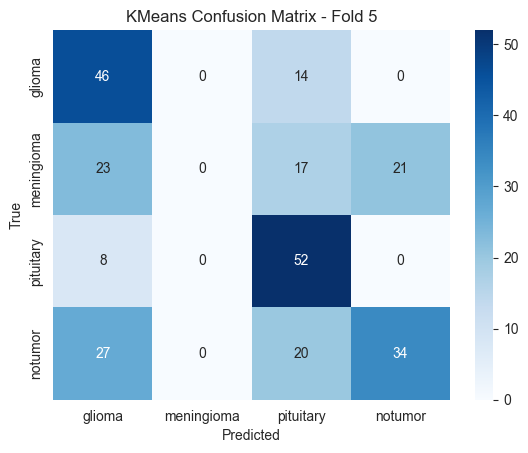


Cross-Validated Accuracy: 0.5316, CV Balanced Accuracy: 0.5429


In [32]:
# Run KMeans with cross-validation
perform_kmeans_with_cv(X_flat=X_scaled, y=y_encoded, n_clusters=4, n_splits=5)

In [54]:
# Define CNN model structure
def create_cnn(input_shape=(64, 64, 3)):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# Train and evaluate the CNN
def train_cnn(X_train_3d, y_train, X_test_3d, y_test):
    cnn_model = create_cnn(input_shape=(64, 64, 3))
    cnn_model.fit(X_train_3d, y_train, epochs=20, batch_size=32, validation_data=(X_test_3d, y_test))

    # Predict and evaluate
    y_pred = np.argmax(cnn_model.predict(X_test_3d), axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2, average='weighted')
    print(f'CNN Accuracy: {accuracy}, Balanced Accuracy: {balanced_accuracy} F2-score: {f2}')
    plot_confusion_matrix(y_test, y_pred, "CNN Confusion Matrix")
    

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_62 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,716 (2.61 MB)

 Trainable params: 683,716 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.3529 - loss: 1.3143 - val_accuracy: 0.6882 - val_loss: 0.9615
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6267 - loss: 0.9344 - val_accuracy: 0.7034 - val_loss: 0.7197
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7499 - loss: 0.6781 - val_accuracy: 0.7262 - val_loss: 0.6732
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7587 - loss: 0.5624 - val_accuracy: 0.7909 - val_loss: 0.5243
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8087 - loss: 0.4789 - val_accuracy: 0.8099 - val_loss: 0.5268
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8550 - loss: 0.3705 - val_accuracy: 0.7947 - val_loss: 0.5166
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8865 - loss: 0.3199 - val_accuracy: 0.8213 - val_loss: 0.4483
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8944 - loss: 0.2936 - val_accuracy: 0.8289 - v

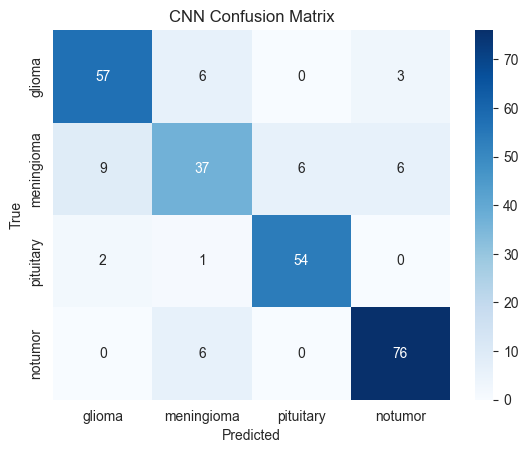

In [55]:

# Run CNN function
train_cnn(X_train_3d, y_train, X_test_3d, y_test)